# Process battery level from app logs

### Convert app logs to time series

In [1]:
import re
from datetime import datetime
import pandas as pd

def process_log(log_name,verbose=False):
    """
    Process specific app log to compute energy usage and prepare data series for plotting
    """
    # Time format to convert string time to unix timetstamp
    time_format = "%Y-%m-%d %H:%M:%S %z"
    # Read log
    with open(log_name, 'r') as file:
        data = file.read()
    # Get experiments: normal vs target condition
    experiments = re.split(r'\n\n', data)
    experiment_series = []
    for experiment in experiments:
        lines = re.split(r'\n',experiment)
        line_count = len(lines)
        # Read the experiment log line by line to get timestamp and battery level
        timestamps = []
        battery_levels = []
        for i in range(line_count):
            # Extract experiment name and start time from the first line
            if i==0:
                start_match = re.search(" Start Experiment: ",lines[i])
                name = lines[i][start_match.end():]
                time_str = lines[i][:start_match.start()]
                time_obj = datetime.strptime(time_str, time_format)
                start_time = int(time_obj.timestamp())
            # Extract timestamp and corresponding battery level
            if i>0 and i<(line_count-3):
                battery_match = re.search(" Current Battery Level: ",lines[i])
                time_str = lines[i][:battery_match.start()]
                time_obj = datetime.strptime(time_str, time_format)
                timestamps.append(int(time_obj.timestamp())-start_time)
                battery_str = lines[i][battery_match.end():]
                battery_levels.append(float(battery_str))
            # Extract end time and end battery level
            if i==(line_count-2):
                end_match = re.search(" Stop Experiment: ",lines[i])
                time_str = lines[i][:end_match.start()]
                time_obj = datetime.strptime(time_str, time_format)
                timestamps.append(int(time_obj.timestamp())-start_time)
            if i==(line_count-1):
                end_battery_match = re.search("End Battery Level ",lines[i])
                battery_str = lines[i][end_battery_match.end():]
                battery_levels.append(float(battery_str))
        # Create a pandas series from processed log
        series = pd.Series(data=battery_levels,index=timestamps,name=name)
        experiment_series.append(series)
        # Compute average power
        # Test device: iPhone 13 mini, 2406 mAh battery capacity
        # Compute battery usage in Wh, assume 3.88V constant discharge rate according to battery specs of the device
        battery_used = (1-battery_levels[-1])*2406*3.88 
        watts = battery_used/(timestamps[-1]/3600)
        if verbose:
            print("Experiment:", name, f", Milliwatts: {watts:.2f}", ", Duration:", timestamps[-1])
        # Also compute baseline without the app
        # Phone had 94% battery left without the app
        if log_name == "normal_vs_none.txt":
            series = pd.Series(data=[1.0,0.94],index=[timestamps[0],timestamps[-1]],name="Idle")
            experiment_series.append(series)
            battery_used = (1-0.94)*2406*3.88 
            watts = battery_used/(timestamps[-1]/3600)
            if verbose:
                print("Experiment: No App", f", Milliwatts: {watts:.2f}", ", Duration:", timestamps[-1])
    return experiment_series
        


### Plot battery usage curve from time series

In [2]:
import matplotlib.pyplot as plt
def plot_battery_usage(log_name):
    """
    From processed app los, plot the battery usage curve
    """
    experiment_series = process_log(log_name)
    for s in experiment_series:
        # Plot battery percentage with respect to hour
        s.index = s.index/3600
        s = s*100
        plt.plot(s,label = s.name)
    plt.xlabel("Hours")
    plt.ylabel("Battery Percentage (%)")
    plt.title("Battery Usage Curve")
    plt.legend()
    plt.grid()
    plt.show()


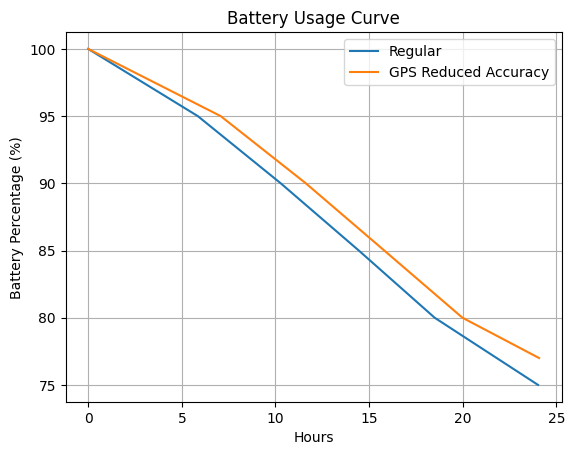

In [3]:
plot_battery_usage("normal_vs_gps_reduced.txt")

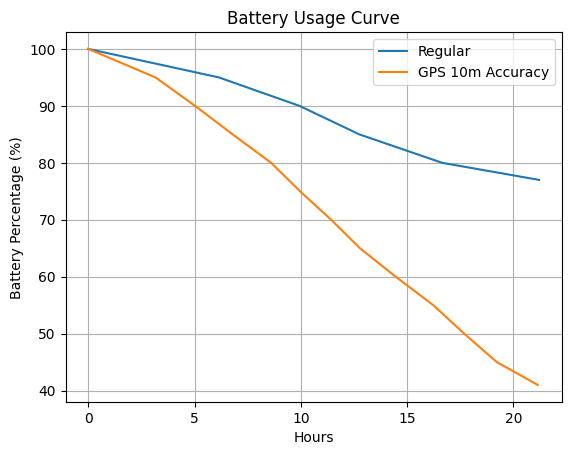

In [4]:
plot_battery_usage("normal_vs_gps_10.txt")

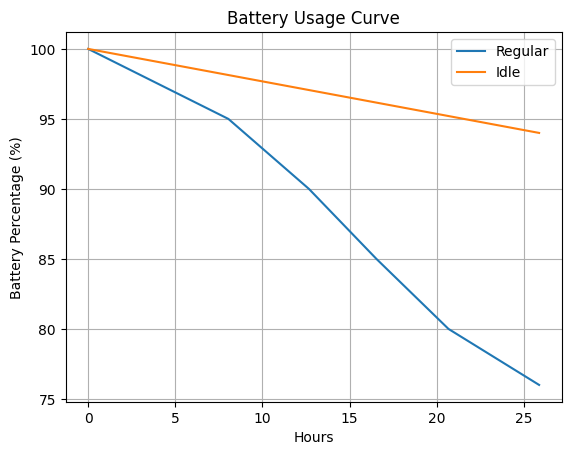

In [5]:
plot_battery_usage("normal_vs_none.txt")

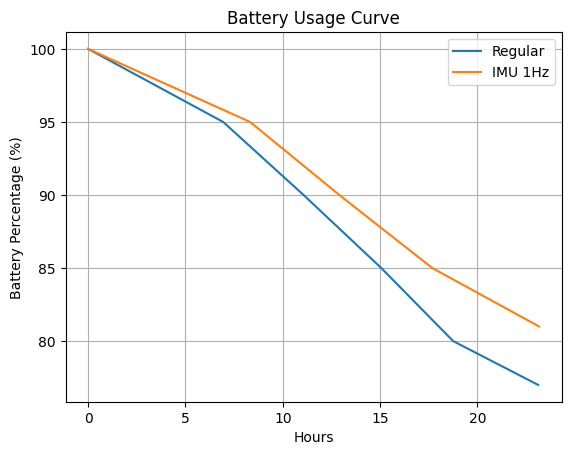

In [6]:
plot_battery_usage("normal_vs_imu_1.txt")

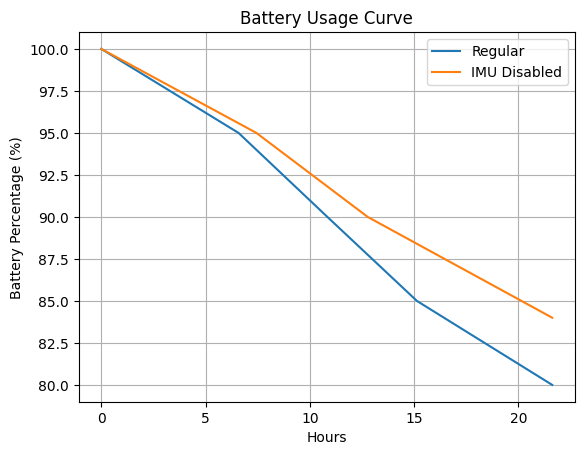

In [7]:
plot_battery_usage("normal_vs_imu_off.txt")

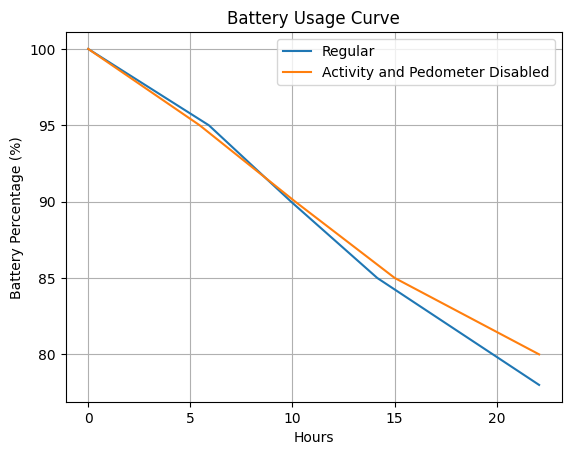

In [8]:
plot_battery_usage("normal_vs_activity_off.txt")

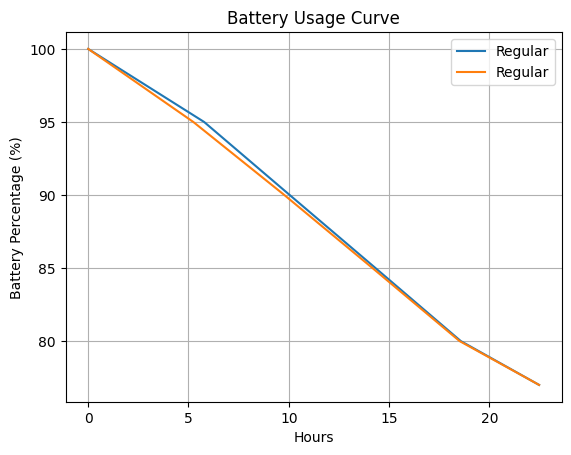

In [9]:
plot_battery_usage("normal_vs_normal.txt")

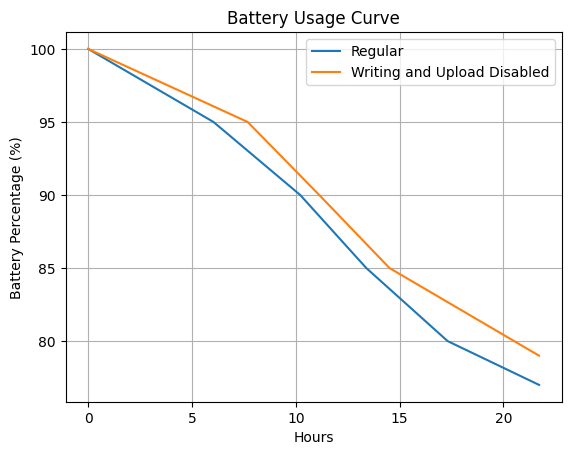

In [10]:
plot_battery_usage("normal_vs_data_off.txt")

### Compute average battery usage curve from multiple runs of normal app

In [11]:
logs = ["normal_vs_gps_10.txt","normal_vs_gps_reduced.txt","normal_vs_none.txt",""
        "normal_vs_imu_1.txt","normal_vs_imu_off.txt","normal_vs_activity_off.txt",
        "normal_vs_normal.txt","normal_vs_data_off.txt"]

In [12]:
def compute_average_usage(logs):
    """
    Compute average and std of battery usage from multiple runs of normal app
    """
    normal_series = []
    energy = []
    time = []
    for l in logs:
        series = process_log(l)
        for s in series:
            # Get the series for normal app configuration
            if s.name =="Regular":
                # Compute energy usage of this series for later averaging
                battery_used = (1-s.values[-1])*2406*3.88 
                energy.append(battery_used)
                time.append(s.index[-1])
                # Lienarly interpolate the series with 1 second interval then resample to 5 minutes
                s_reindexd = s.reindex(range(s.index.min(), s.index.max()+1))
                s_interpolated = s_reindexd.interpolate(method="linear")
                s_resampled = s_interpolated.reindex(range(s.index.min(), s.index.max()+1,300))
                normal_series.append(s_resampled)
    # Compute weighted average and std battery usage from all normal app series
    average_power = sum(energy)/(sum(time)/3600)
    std_sum = 0
    for i in range(len(energy)):
        std_sum += time[i]*(energy[i]/(time[i]/3600)-average_power)**2
    std_power = (std_sum/sum(time))**(1/2)
    print("Experiment: Average Regular", f", Milliwatts: {average_power:.2f} +/- {std_power:.2f}")
    # Get average battery usage curve
    df = pd.concat(normal_series,axis=1)
    df = df.dropna(axis=0)
    average_usage = df.mean(axis=1)
    average_usage.name = "Average Regular"
    std_usage = df.std(axis=1)
    return average_usage,std_usage


### Plot battery usage curves from all experiments

In [13]:
def plot_all(logs):
    """
    Plot all battery usage curves in one graph
    """
    plt.figure(figsize=(12,5))
    for l in logs:
        print(l)
        series = process_log(l,verbose=True)
        # Plot each battery usage curve
        for s in series:
            s.index = s.index/3600
            s = s*100
            if s.name != "Regular":
                plt.plot(s,label = s.name)
    # Plot average battery usage curvbe for normal app
    average_normal,std_normal = compute_average_usage(logs)
    average_normal.index = average_normal.index/3600
    std_normal.index = std_normal.index/3600
    average_normal = average_normal*100
    std_normal = std_normal*100
    plt.plot(average_normal,label = average_normal.name)
    plt.fill_between(average_normal.index,average_normal-std_normal,average_normal+std_normal,alpha=0.25)
    plt.xlabel("Hours")
    plt.ylabel("Battery Percentage (%)")
    plt.title("Battery Usage Curve")
    plt.legend()
    plt.grid()
    plt.show()
            

normal_vs_gps_10.txt
Experiment: Regular , Milliwatts: 101.25 , Duration: 76341
Experiment: GPS 10m Accuracy , Milliwatts: 260.52 , Duration: 76111
normal_vs_gps_reduced.txt
Experiment: Regular , Milliwatts: 97.17 , Duration: 86465
Experiment: GPS Reduced Accuracy , Milliwatts: 89.19 , Duration: 86667
normal_vs_none.txt
Experiment: Regular , Milliwatts: 86.61 , Duration: 93131
Experiment: No App , Milliwatts: 21.65 , Duration: 93131
normal_vs_imu_1.txt
Experiment: Regular , Milliwatts: 92.83 , Duration: 83263
Experiment: IMU 1Hz , Milliwatts: 76.53 , Duration: 83434
normal_vs_imu_off.txt
Experiment: Regular , Milliwatts: 86.32 , Duration: 77862
Experiment: IMU Disabled , Milliwatts: 69.06 , Duration: 77861
normal_vs_activity_off.txt
Experiment: Regular , Milliwatts: 93.04 , Duration: 79462
Experiment: Activity and Pedometer Disabled , Milliwatts: 84.59 , Duration: 79462
normal_vs_normal.txt
Experiment: Regular , Milliwatts: 95.50 , Duration: 80940
Experiment: Regular , Milliwatts: 95.5

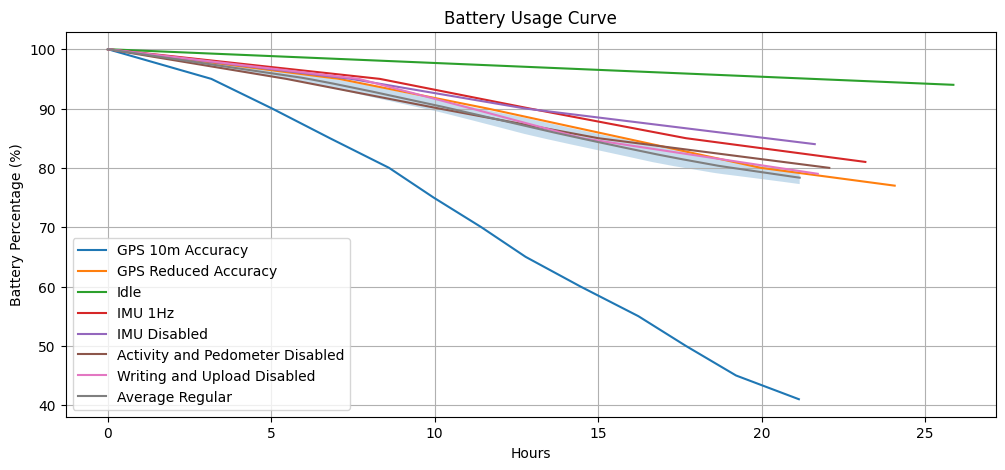

In [14]:
plot_all(logs)